In [91]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,label_binarize
from keras.layers import concatenate,Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate,Dropout,Softmax,BatchNormalization,Activation,DepthwiseConv2D ,ReLU,Add,GlobalAveragePooling2D,Multiply,Average
from keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import load_img,img_to_array,array_to_img
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau,LearningRateScheduler

In [92]:
dataset_path = 'D:\Dataset\Rice_Image_Dataset'
images = []
labels = []
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})

In [93]:
X_train, X_remaining, Y_train, Y_remaining = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42)
test_ratio = 0.5
X_val, X_test, Y_val, Y_test = train_test_split(X_remaining, Y_remaining, test_size=test_ratio, random_state=42)
df_train = pd.DataFrame({'image': X_train, 'label': Y_train})
df_val = pd.DataFrame({'image': X_val, 'label': Y_val})
df_test = pd.DataFrame({'image': X_test, 'label': Y_test})
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_val = encoder.transform(Y_val)
Y_test = encoder.transform(Y_test)

In [94]:
input_shape=(50, 50, 3)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


In [95]:
class Spatial_Attention(tf.keras.layers.Layer):
    def __init__(self, num_filter):
        super(Spatial_Attention, self).__init__()
        self.conv1 = Conv2D(num_filter // 8, kernel_size=1, strides=1, padding='valid')
        self.conv2 = Conv2D(num_filter // 8, kernel_size=1, strides=1, padding='valid')
        self.conv3 = Conv2D(num_filter, kernel_size=1, strides=1, padding='valid')
    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        attention_maps = tf.nn.sigmoid(x)
        attention_maps = tf.keras.layers.multiply([inputs, attention_maps])
        return attention_maps

In [96]:
class Channel_Attention(tf.keras.layers.Layer):
    def __init__(self, channels):
        super(Channel_Attention, self).__init__()
        self.channels=channels
        self.conv1= Conv2D(self.channels, kernel_size=1, strides=1, padding='valid')
        self.conv2= Conv2D(self.channels, kernel_size=1, strides=1, padding='valid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.softmax(x, axis=-1) 
        return x

In [97]:
def residual_block_with_spatial_attention(inputs, num_filter):
    x = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    if inputs.shape[-1] != num_filter:
        shortcut = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    attention = Spatial_Attention(num_filter)(x)
    x = Multiply()([attention, x])
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [98]:
def residual_block_with_channel_attention(inputs, num_filter):
    x = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)   
    x = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    if inputs.shape[-1] != num_filter:
        shortcut = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    attention = Channel_Attention(num_filter)(x)
    x = Multiply()([attention, x])
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [99]:
def ResNet_with_channel_spatial_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)
    x = Activation('relu')(x)   
    x = residual_block_with_channel_attention(x, 32)
    x = residual_block_with_spatial_attention(x, 64)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)   
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [100]:
from tensorflow.keras.regularizers import l2
def Kai_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same")(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same")(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    attention = Channel_Attention(channels=128)(pool3)
    attention_maps = tf.multiply(pool3, attention)
    concatenate_maps = Concatenate()([pool3, attention_maps])
    regularization = Conv2D(128, kernel_size=(1, 1), activation='relu', padding='same')(concatenate_maps)
    flatten = Flatten()(regularization)
    fc1 = Dense(256, activation='relu')(flatten)
    dropout1 = Dropout(0.2)(fc1)
    output = Dense(num_classes, activation='softmax')(dropout1)
    model = Model(inputs=inputs, outputs=output)
    return model

In [101]:
input_shape = (50, 50, 3)
num_classes = 5

def create_ensemble_model(input_shape):
    input_layer = Input(shape=input_shape)
    model1 = ResNet_with_channel_spatial_attention(input_shape,num_classes)(input_layer)
    model2 = Kai_cnn(input_shape,num_classes)(input_layer)
    merged = concatenate([model1, model2])
    dense = Dense(128,activation="relu")(merged)
    output_layer = Dense(num_classes, activation='softmax')(dense)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model1 = ResNet_with_channel_spatial_attention(input_shape, num_classes)
model2 = Kai_cnn(input_shape, num_classes)
model = create_ensemble_model(input_shape)


In [102]:
model1.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d_102 (Conv2D)            (None, 50, 50, 32)   416         ['input_28[0][0]']               
                                                                                                  
 batch_normalization_36 (BatchN  (None, 50, 50, 32)  128         ['conv2d_102[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 25, 25, 32)  0           ['batch_normalization_36[0

In [103]:
model2.summary()

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d_113 (Conv2D)            (None, 50, 50, 32)   896         ['input_29[0][0]']               
                                                                                                  
 max_pooling2d_25 (MaxPooling2D  (None, 25, 25, 32)  0           ['conv2d_113[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 25, 25, 64)   18496       ['max_pooling2d_25[0][0]']

In [104]:
model.summary(expand_nested=True)

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 model_44 (Functional)          (None, 5)            63989       ['input_30[0][0]']               
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_31 (InputLayer)        [(None, 50, 50, 3)]  0           []                               |
|                                                                                                |
| conv2d_119 (Conv2D)          (None, 50, 50, 32)   416         []                               |
|                                                                                          

In [105]:
import tensorflow as tf
def custom_loss(y_true, y_pred,label_smoothing=0.1):
    epsilon = tf.keras.backend.epsilon()
    y_true_smoothed = y_true * (1.0 - label_smoothing) + label_smoothing / num_classes
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    cce = -tf.reduce_sum(y_true_smoothed * tf.math.log(y_pred), axis=-1)
    return tf.reduce_mean(cce)
def custom_accuracy(y_true, y_pred):
    correct_predictions = tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [106]:
optimizer = Adam(learning_rate=0.001)

In [107]:
def lr_scheduler(epoch, learning_rate):
    decay_rate = 0.1
    decay_step = 3
    if epoch % decay_step == 0 and epoch:
        return learning_rate * decay_rate
    return learning_rate

In [108]:
reduce_lr = LearningRateScheduler(lr_scheduler)

In [109]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [110]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        super(MetricsCallback, self).__init__()
        self.model = model
        self.precision = []
        self.recall = []
        self.f1_score = []
    
    def on_epoch_end(self, epoch, logs=None):
        y_true = val_generator.labels
        y_pred = np.argmax(self.model.predict(val_generator), axis=-1)
        precision = tf.keras.metrics.Precision()(y_true, y_pred)
        recall = tf.keras.metrics.Recall()(y_true, y_pred)
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        self.precision.append(precision)
        self.recall.append(recall)
        self.f1_score.append(f1_score)
        print(f'Epoch {epoch+1}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1_score:.4f}')

In [84]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load each model with pretrained weights and customize the top layer
def load_model(model_base, input_shape, num_classes):
    base_model = model_base(weights=None, include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Compile and train each model, and return the history
def train_model(model, train_data, val_data, epochs):
    model.compile(loss=custom_loss, optimizer=optimizer, metrics=[custom_accuracy])
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    return history


# Load models
input_shape = (50, 50, 3)  # Example input shape
num_classes = 5  # Example number of classes
epochs = 10  # Example number of epochs
resnet_model = load_model(ResNet50, input_shape, num_classes)
vgg_model = load_model(VGG16, input_shape, num_classes)
efficientnet_model = load_model(EfficientNetB0, input_shape, num_classes)
mobilenet_model = load_model(MobileNet, input_shape, num_classes)

# Train models and collect histories
histories = {}
histories['ResNet'] = train_model(resnet_model, train_generator, val_generator, 10)


Epoch 1/10
1641/1641 [==============================] - 101s 59ms/step - loss: 1.3863 - custom_accuracy: 0.4261 - val_loss: 1.2996 - val_custom_accuracy: 0.4700
Epoch 2/10
1641/1641 [==============================] - 100s 61ms/step - loss: 1.3098 - custom_accuracy: 0.4571 - val_loss: 1.2468 - val_custom_accuracy: 0.4974
Epoch 3/10
1641/1641 [==============================] - 101s 62ms/step - loss: 1.2660 - custom_accuracy: 0.4864 - val_loss: 1.2194 - val_custom_accuracy: 0.5191
Epoch 4/10
1641/1641 [==============================] - 102s 62ms/step - loss: 1.2424 - custom_accuracy: 0.4973 - val_loss: 1.1767 - val_custom_accuracy: 0.5411
Epoch 5/10
1641/1641 [==============================] - 102s 62ms/step - loss: 1.2086 - custom_accuracy: 0.5194 - val_loss: 1.1574 - val_custom_accuracy: 0.5547
Epoch 6/10
1641/1641 [==============================] - 102s 62ms/step - loss: 1.1900 - custom_accuracy: 0.5334 - val_loss: 1.1426 - val_custom_accuracy: 0.5616
Epoch 7/10
1641/1641 [============

In [85]:
histories['VGG'] = train_model(vgg_model, train_generator, val_generator, 10)

Epoch 1/10
1641/1641 [==============================] - 79s 47ms/step - loss: 1.2161 - custom_accuracy: 0.5740 - val_loss: 0.9564 - val_custom_accuracy: 0.7309
Epoch 2/10
1641/1641 [==============================] - 79s 48ms/step - loss: 0.8774 - custom_accuracy: 0.7518 - val_loss: 0.8292 - val_custom_accuracy: 0.7737
Epoch 3/10
1641/1641 [==============================] - 80s 49ms/step - loss: 0.8177 - custom_accuracy: 0.7847 - val_loss: 0.8010 - val_custom_accuracy: 0.7924
Epoch 4/10
1641/1641 [==============================] - 81s 49ms/step - loss: 0.8001 - custom_accuracy: 0.7951 - val_loss: 0.7862 - val_custom_accuracy: 0.8053
Epoch 5/10
1641/1641 [==============================] - 82s 50ms/step - loss: 0.7899 - custom_accuracy: 0.8023 - val_loss: 0.7806 - val_custom_accuracy: 0.8052
Epoch 6/10
1641/1641 [==============================] - 82s 50ms/step - loss: 0.7769 - custom_accuracy: 0.8104 - val_loss: 0.7695 - val_custom_accuracy: 0.8164
Epoch 7/10
1641/1641 [==================

In [86]:
histories['EfficientNet'] = train_model(efficientnet_model, train_generator, val_generator, 10)

Epoch 1/10
1641/1641 [==============================] - 126s 72ms/step - loss: 1.5330 - custom_accuracy: 0.2950 - val_loss: 1.5451 - val_custom_accuracy: 0.2803
Epoch 2/10
1641/1641 [==============================] - 119s 73ms/step - loss: 1.5114 - custom_accuracy: 0.3121 - val_loss: 1.5243 - val_custom_accuracy: 0.2915
Epoch 3/10
1641/1641 [==============================] - 120s 73ms/step - loss: 1.4915 - custom_accuracy: 0.3241 - val_loss: 1.5128 - val_custom_accuracy: 0.2948
Epoch 4/10
1641/1641 [==============================] - 120s 73ms/step - loss: 1.4858 - custom_accuracy: 0.3240 - val_loss: 1.4963 - val_custom_accuracy: 0.3050
Epoch 5/10
1641/1641 [==============================] - 119s 72ms/step - loss: 1.4726 - custom_accuracy: 0.3368 - val_loss: 1.4812 - val_custom_accuracy: 0.3153
Epoch 6/10
1641/1641 [==============================] - 119s 72ms/step - loss: 1.4610 - custom_accuracy: 0.3442 - val_loss: 1.4726 - val_custom_accuracy: 0.3239
Epoch 7/10
1641/1641 [============

In [87]:
histories['MobileNet'] = train_model(mobilenet_model,  train_generator, val_generator, 10)

Epoch 1/10
1641/1641 [==============================] - 74s 44ms/step - loss: 1.7506 - custom_accuracy: 0.2426 - val_loss: 1.6910 - val_custom_accuracy: 0.2683
Epoch 2/10
1641/1641 [==============================] - 72s 44ms/step - loss: 1.6787 - custom_accuracy: 0.2702 - val_loss: 1.6528 - val_custom_accuracy: 0.2769
Epoch 3/10
1641/1641 [==============================] - 72s 44ms/step - loss: 1.6534 - custom_accuracy: 0.2766 - val_loss: 1.6333 - val_custom_accuracy: 0.2871
Epoch 4/10
1641/1641 [==============================] - 71s 43ms/step - loss: 1.6375 - custom_accuracy: 0.2836 - val_loss: 1.6147 - val_custom_accuracy: 0.2898
Epoch 5/10
1641/1641 [==============================] - 71s 43ms/step - loss: 1.6198 - custom_accuracy: 0.2852 - val_loss: 1.6040 - val_custom_accuracy: 0.2992
Epoch 6/10
1641/1641 [==============================] - 74s 45ms/step - loss: 1.6066 - custom_accuracy: 0.2942 - val_loss: 1.5950 - val_custom_accuracy: 0.2978
Epoch 7/10
1641/1641 [==================

In [89]:
# Plot histories
def plot_histories(histories):
    plt.figure(figsize=(10, 6))
    models = ['ResNet50', 'VGG16', 'EfficientNetB0', 'MobileNet']
    for name, history in zip(models, histories):
        plt.plot(history.history['custom_accuracy'], label=f'{name} Training Accuracy')
        plt.plot(history.history['val_custom_accuracy'], label=f'{name} Validation Accuracy')
    plt.title('Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_histories(histories, 'accuracy')

TypeError: plot_histories() takes 1 positional argument but 2 were given

Epoch 1/10
1641/1641 [==============================] - 71s 42ms/step - loss: 0.6571 - custom_accuracy: 0.9077 - val_loss: 0.5073 - val_custom_accuracy: 0.9642 - lr: 0.0010
Epoch 2/10
1641/1641 [==============================] - 70s 42ms/step - loss: 0.5311 - custom_accuracy: 0.9642 - val_loss: 0.8745 - val_custom_accuracy: 0.7733 - lr: 0.0010
Epoch 3/10
1641/1641 [==============================] - 70s 42ms/step - loss: 0.5095 - custom_accuracy: 0.9703 - val_loss: 0.5053 - val_custom_accuracy: 0.9734 - lr: 0.0010
Epoch 4/10
1641/1641 [==============================] - 68s 42ms/step - loss: 0.4746 - custom_accuracy: 0.9838 - val_loss: 0.4397 - val_custom_accuracy: 0.9888 - lr: 1.0000e-04
Epoch 5/10
1641/1641 [==============================] - 70s 43ms/step - loss: 0.4683 - custom_accuracy: 0.9858 - val_loss: 0.4334 - val_custom_accuracy: 0.9921 - lr: 1.0000e-04
Epoch 6/10
1641/1641 [==============================] - 70s 42ms/step - loss: 0.4630 - custom_accuracy: 0.9876 - val_loss: 0.43

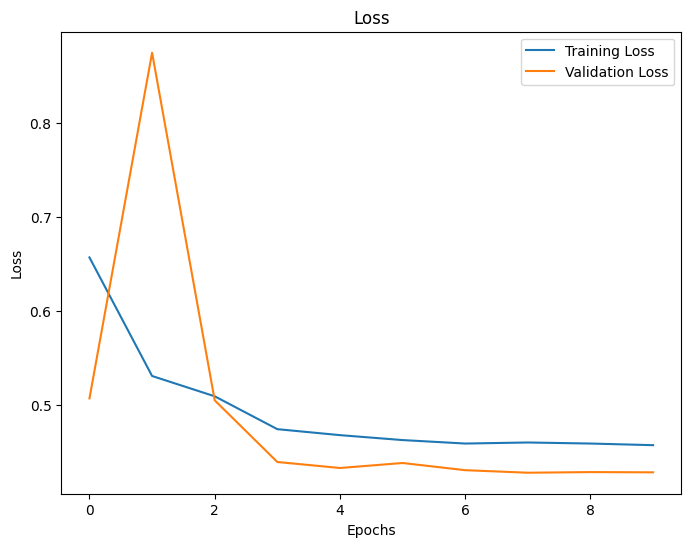

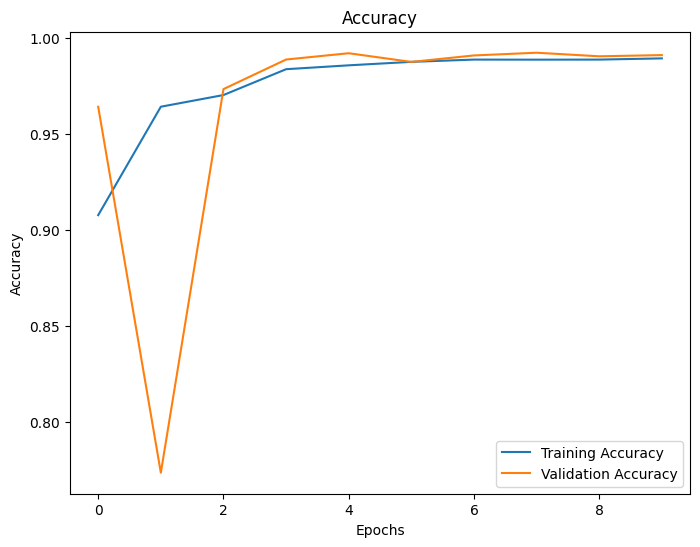

352/352 [==============================] - 12s 34ms/step - loss: 0.4318 - custom_accuracy: 0.9894
test_results: 0.9894353747367859


In [21]:
model1.compile(loss=custom_loss, optimizer=optimizer, metrics=[custom_accuracy])
history = model1.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[reduce_lr,early_stopping])
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
test_results = model1.evaluate(test_generator)
print('test_results:', test_results[1])

Epoch 1/10
1641/1641 [==============================] - 69s 41ms/step - loss: 0.6833 - custom_accuracy: 0.8599 - val_loss: 0.4999 - val_custom_accuracy: 0.9554 - lr: 0.0010
Epoch 2/10
1641/1641 [==============================] - 67s 41ms/step - loss: 0.4881 - custom_accuracy: 0.9644 - val_loss: 0.5371 - val_custom_accuracy: 0.9309 - lr: 0.0010
Epoch 3/10
1641/1641 [==============================] - 67s 41ms/step - loss: 0.4684 - custom_accuracy: 0.9722 - val_loss: 0.4292 - val_custom_accuracy: 0.9859 - lr: 0.0010
Epoch 4/10
1641/1641 [==============================] - 68s 41ms/step - loss: 0.4268 - custom_accuracy: 0.9902 - val_loss: 0.4146 - val_custom_accuracy: 0.9916 - lr: 1.0000e-04
Epoch 5/10
1641/1641 [==============================] - 68s 41ms/step - loss: 0.4229 - custom_accuracy: 0.9908 - val_loss: 0.4160 - val_custom_accuracy: 0.9901 - lr: 1.0000e-04
Epoch 6/10
1641/1641 [==============================] - 67s 41ms/step - loss: 0.4203 - custom_accuracy: 0.9917 - val_loss: 0.40

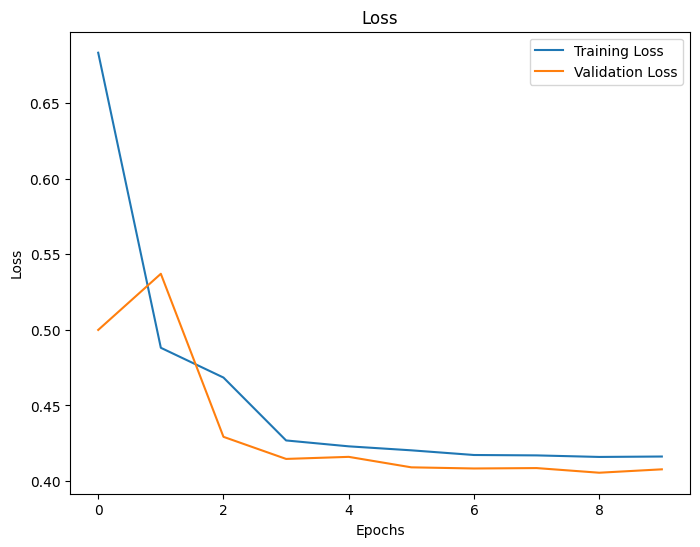

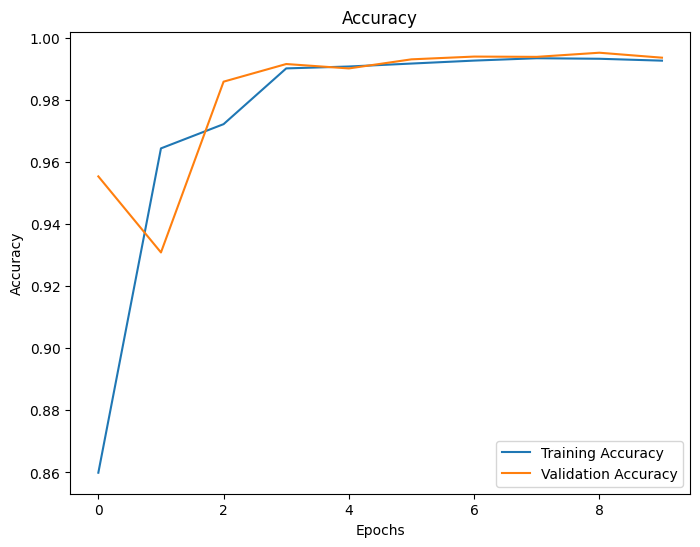

352/352 [==============================] - 12s 33ms/step - loss: 0.4099 - custom_accuracy: 0.9929
test_results: 0.9928977489471436


In [34]:
model2.compile(loss=custom_loss, optimizer=optimizer, metrics=[custom_accuracy])
history = model2.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[reduce_lr,early_stopping])
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
test_results = model2.evaluate(test_generator)
print('test_results:', test_results[1])

In [111]:
ensemble_model_metrics_callback = MetricsCallback(model)

In [112]:
model.compile(loss=custom_loss, optimizer=optimizer, metrics=[custom_accuracy])

In [113]:
history = model.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[ensemble_model_metrics_callback])

Epoch 1/10
352/352 [==============================] - 13s 35ms/step
Epoch 1: Precision = 0.9951, Recall = 0.9740, F1-Score = 0.9845
1641/1641 [==============================] - 107s 64ms/step - loss: 0.6332 - custom_accuracy: 0.8888 - val_loss: 0.4883 - val_custom_accuracy: 0.9564
Epoch 2/10
352/352 [==============================] - 12s 35ms/step
Epoch 2: Precision = 0.8935, Recall = 0.9977, F1-Score = 0.9427
1641/1641 [==============================] - 85s 52ms/step - loss: 0.4792 - custom_accuracy: 0.9633 - val_loss: 0.7007 - val_custom_accuracy: 0.8441
Epoch 3/10
352/352 [==============================] - 13s 36ms/step
Epoch 3: Precision = 0.9971, Recall = 0.9652, F1-Score = 0.9809
1641/1641 [==============================] - 86s 52ms/step - loss: 0.4564 - custom_accuracy: 0.9742 - val_loss: 0.5508 - val_custom_accuracy: 0.9313
Epoch 4/10
352/352 [==============================] - 12s 35ms/step
Epoch 4: Precision = 0.9950, Recall = 0.8433, F1-Score = 0.9129
1641/1641 [=============

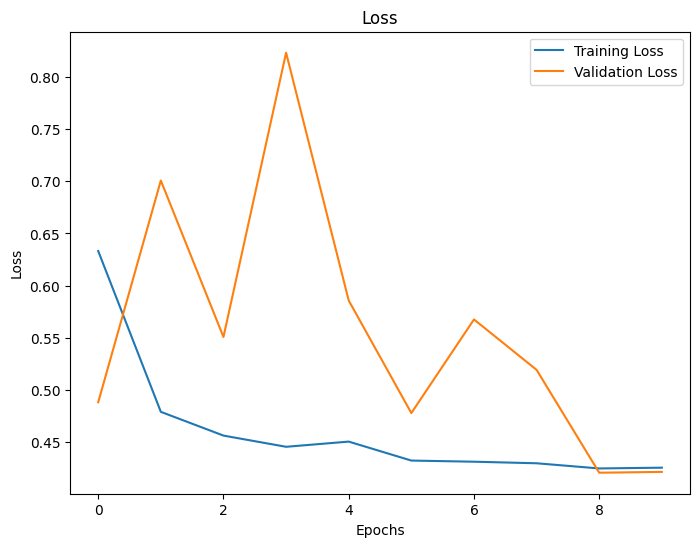

In [115]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

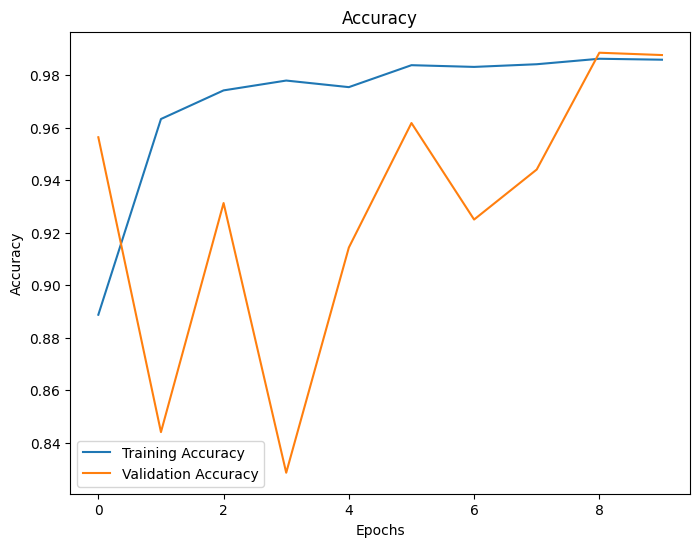

In [116]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

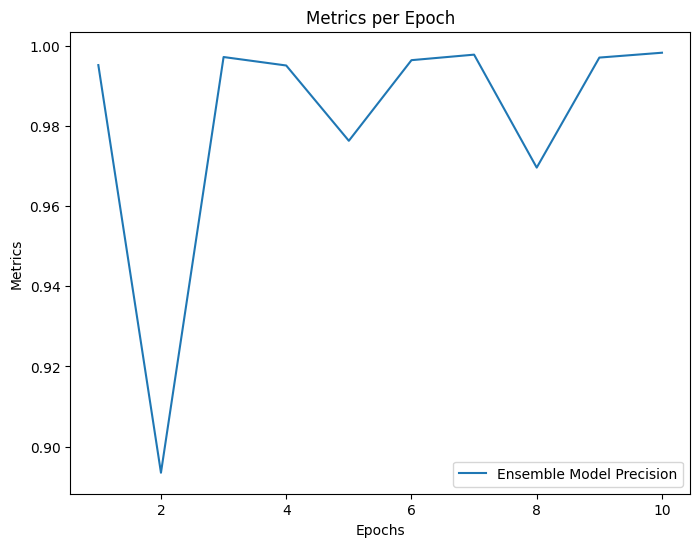

In [117]:
x = np.arange(1, 11)
plt.figure(figsize=(8, 6))
plt.plot(x, ensemble_model_metrics_callback.precision, label='Ensemble Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Metrics per Epoch')
plt.legend()
plt.show()

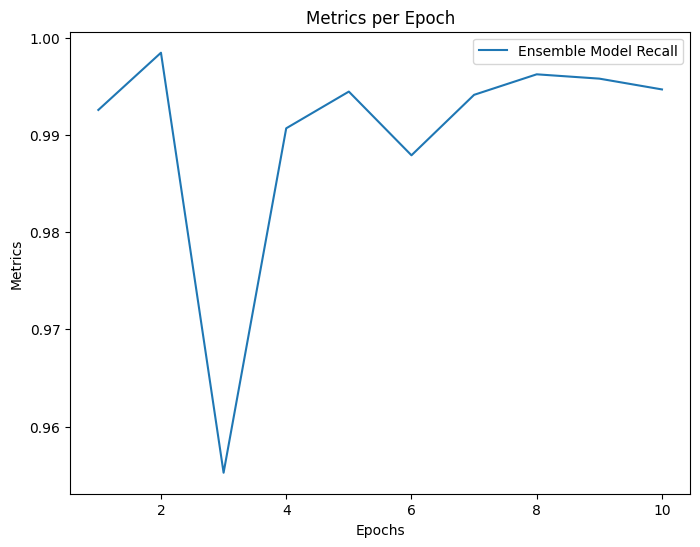

In [64]:
x = np.arange(1, 11)
plt.figure(figsize=(8, 6))
plt.plot(x, ensemble_model_metrics_callback.recall, label='Ensemble Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Metrics per Epoch')
plt.legend()
plt.show()

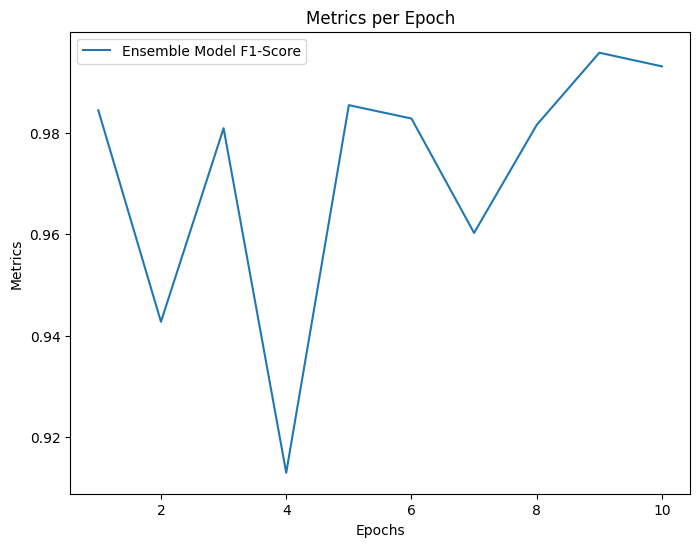

In [118]:
x = np.arange(1, 11)
plt.figure(figsize=(8, 6))
plt.plot(x, ensemble_model_metrics_callback.f1_score, label='Ensemble Model F1-Score')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Metrics per Epoch')
plt.legend()
plt.show()

In [119]:
test_results = model.evaluate(test_generator)
print('test_results:', test_results[1])

352/352 [==============================] - 15s 44ms/step - loss: 0.4259 - custom_accuracy: 0.9856
test_results: 0.9856178760528564


In [67]:
y_pred= model.predict(test_generator)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)
rice_classed=df_test["label"].unique()
print(classification_report(y_true, y_pred_classes,target_names = rice_classed))

352/352 [==============================] - 12s 35ms/step
              precision    recall  f1-score   support

   Karacadag       0.98      0.99      0.99      2229
     Basmati       1.00      0.99      0.99      2227
      Ipsala       1.00      1.00      1.00      2368
     Arborio       0.98      0.99      0.99      2261
     Jasmine       1.00      0.99      0.99      2165

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



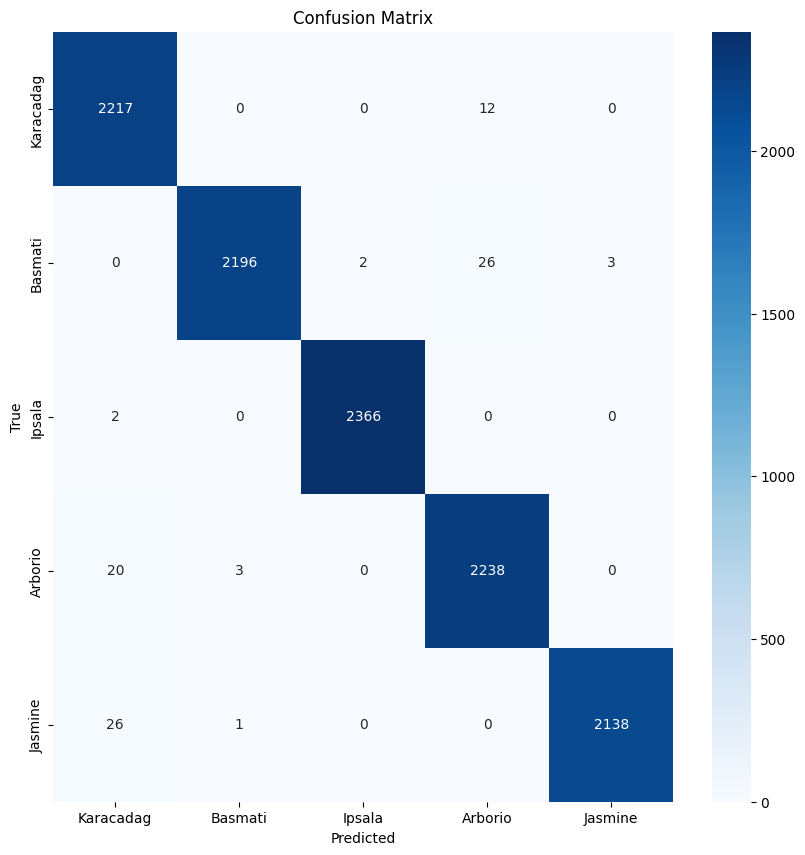

In [68]:
rice_classed=df_test["label"].unique()
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(cm,annot=True,cmap='Blues', fmt='d', xticklabels=rice_classed, yticklabels=rice_classed)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [80]:
cm = confusion_matrix(y_true, y_pred_classes)
sensitivity_per_class = recall_score(y_true, y_pred_classes, average=None)
specificity_per_class = []
for i in range(cm.shape[0]):
    true_negatives = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    specificity_per_class.append(true_negatives / (true_negatives + false_positives))
print("Sensitivity for each class:", sensitivity_per_class)
print("Specificity for each class:", specificity_per_class)

Sensitivity for each class: [0.99461642 0.98607993 0.99915541 0.98982751 0.98752887]
Specificity for each class: [0.9946790821416694, 0.9995566884628172, 0.9997748254897546, 0.9957726109689621, 0.9996697853604843]


352/352 [==============================] - 12s 35ms/step


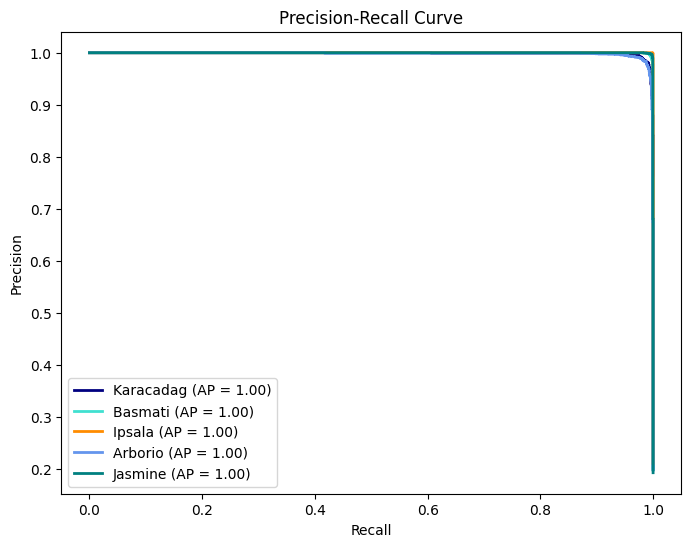

In [70]:
from itertools import cycle
test_predictions = model.predict(test_generator)
num_classes = len(np.unique(Y_test))
Y_test_bin = label_binarize(Y_test, classes=np.arange(num_classes))
precision = []
recall = []
average_precision = []
for i in range(num_classes):
    precision_i, recall_i, _ = precision_recall_curve(Y_test_bin[:, i], test_predictions[:, i])
    average_precision_i = average_precision_score(Y_test_bin[:, i], test_predictions[:, i])    
    precision.append(precision_i)
    recall.append(recall_i)
    average_precision.append(average_precision_i)
plt.figure(figsize=(8, 6))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
for i, color in zip(range(num_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'{rice_classed[i]} (AP = {average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

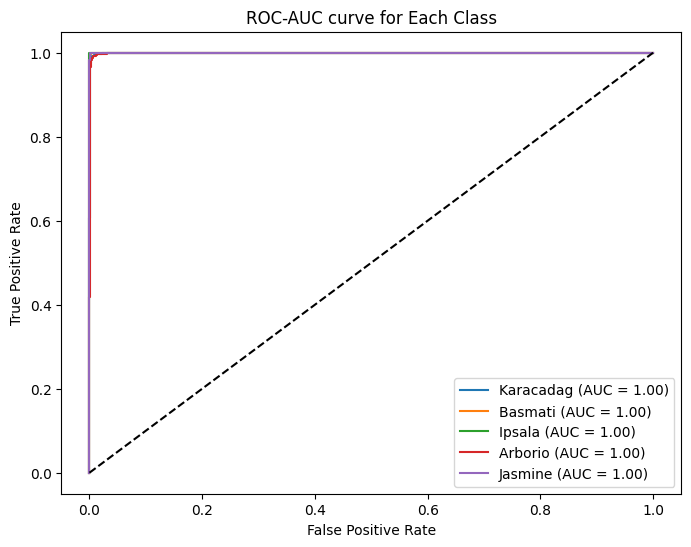

In [71]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true, test_predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{rice_classed[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve for Each Class')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 18ms/step


C:\Users\AW\AppData\Local\Temp\ipykernel_18740\4273784717.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


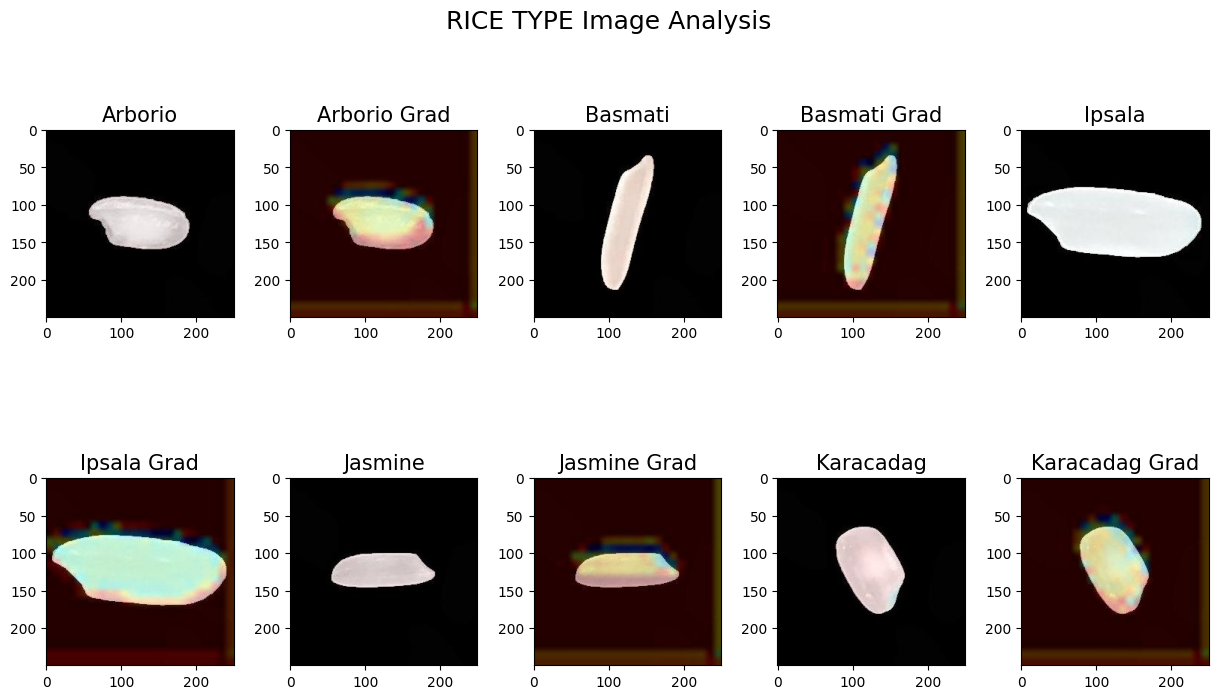

In [73]:
import matplotlib.cm as cm
list_images_sample = ["D:/Dataset/Rice_Image_Dataset/Arborio/Arborio (1).jpg",
"D:/Dataset/Rice_Image_Dataset/Basmati/Basmati (1).jpg",
"D:/Dataset/Rice_Image_Dataset/Ipsala/Ipsala (1).jpg",
"D:/Dataset/Rice_Image_Dataset/Jasmine/Jasmine (1).jpg",
"D:/Dataset/Rice_Image_Dataset/Karacadag/Karacadag (1).jpg"]

model_builder = keras.applications.xception.Xception
img_size = (50, 50)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "activation_24"
# To Get Image into numpy array

def get_img_array(img_path, size):
    img = load_img(img_path, target_size = size) 
    array = img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Storing Heatmap values into list

covid_noncovid_heatmap = []

for i in list_images_sample:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model1
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)
# To Display GradCAM output for the samples

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(list_images_sample)):
    save_and_display_gradcam(list_images_sample[i], covid_noncovid_heatmap[i])
    
    
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()
    
    

titles_list = ["Arborio",'Arborio Grad','Basmati','Basmati Grad','Ipsala','Ipsala Grad','Jasmine','Jasmine Grad','Karacadag','Karacadag Grad']

plot_multiple_img(imag, titles_list, ncols = 5, main_title = "RICE TYPE Image Analysis")

1/1 [==============================] - 0s 20ms/step


C:\Users\AW\AppData\Local\Temp\ipykernel_18740\3335771608.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


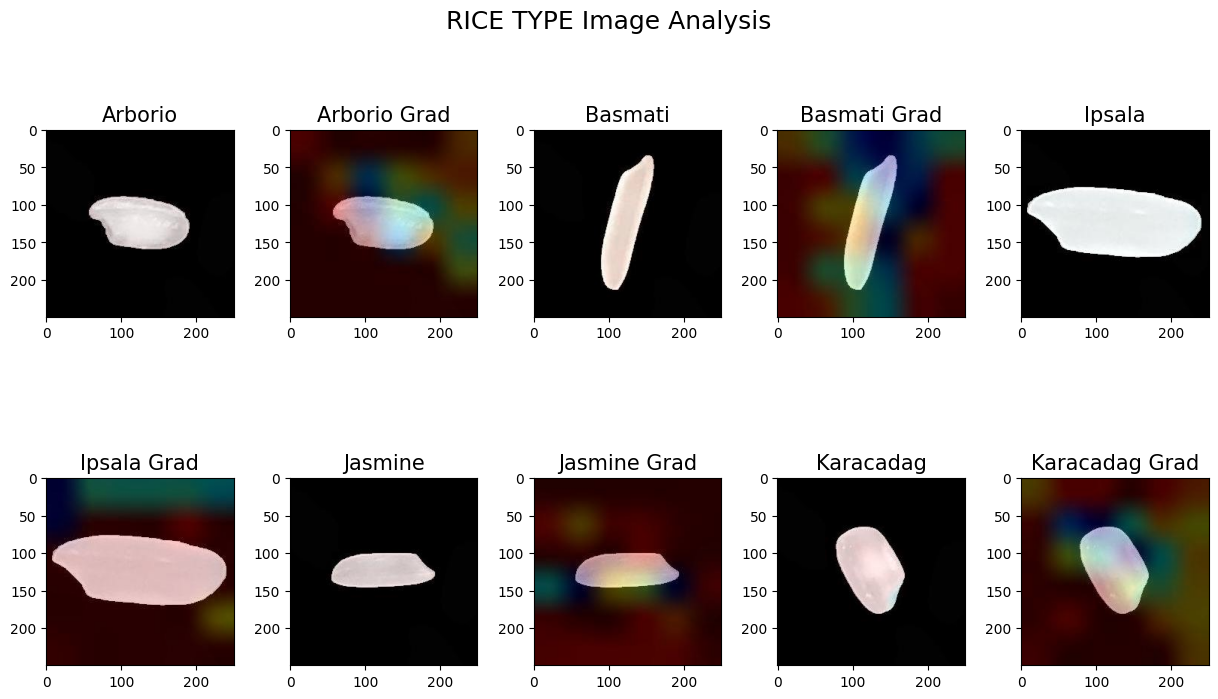

In [78]:
import matplotlib.cm as cm
list_images_sample = ["D:/Dataset/Rice_Image_Dataset/Arborio/Arborio (1).jpg",
"D:/Dataset/Rice_Image_Dataset/Basmati/Basmati (1).jpg",
"D:/Dataset/Rice_Image_Dataset/Ipsala/Ipsala (1).jpg",
"D:/Dataset/Rice_Image_Dataset/Jasmine/Jasmine (1).jpg",
"D:/Dataset/Rice_Image_Dataset/Karacadag/Karacadag (1).jpg"]

model_builder = keras.applications.xception.Xception
img_size = (50, 50)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "conv2d_84"
# To Get Image into numpy arrayconcatenate_6

def get_img_array(img_path, size):
    img = load_img(img_path, target_size = size) 
    array = img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Storing Heatmap values into list

covid_noncovid_heatmap = []

for i in list_images_sample:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model2
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)
# To Display GradCAM output for the samples

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(list_images_sample)):
    save_and_display_gradcam(list_images_sample[i], covid_noncovid_heatmap[i])
    
    
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()
    
    

titles_list = ["Arborio",'Arborio Grad','Basmati','Basmati Grad','Ipsala','Ipsala Grad','Jasmine','Jasmine Grad','Karacadag','Karacadag Grad']

plot_multiple_img(imag, titles_list, ncols = 5, main_title = "RICE TYPE Image Analysis")